In [1]:
%run imports.ipy

Couldn't import dot_parser, loading of dot files will not be possible.


# Sanity Check - Maze without Walls

## Maze

In [2]:
# maze shape
H = W = 8
gamma = 0.9

# generate task progression.
def gen_tasks(worlds, wall_penalty=0., gamma=gamma):
    for world in worlds:
        grid = Grid(world, action_stoch=0.2)
        for num_goals in range(1,2):
            goal_pos_index = npr.choice(range(len(grid.free_pos)), num_goals, replace=False)
            goal = {grid.free_pos[ind]: 1 for ind in goal_pos_index}
            rewards = dict(goal)
            demons = {}
            yield GridWorldUltimate(grid, goal, demons, rewards, wall_penalty=wall_penalty, gamma=gamma)

tasks_ladder = map(gen_tasks, 
            [[np.zeros((H, W)) for i in range(1, 6)],
            ]
        )
# make dataset for supervised learning.
allow_init_pos_in_rewards = False
datasets = []
for tasks in tasks_ladder:
    dataset = []
    for task in tasks:
        values = solve_task_by_value_iteration(task)
        for pos in task.env.free_pos:
            if not allow_init_pos_in_rewards and pos in task.rewards:
                continue
            agent_state = np.zeros_like(task.env.grid)
            agent_state[pos] = 1.
            dataset.append((task.wrap_state(agent_state), values[pos]))
    datasets.append(dataset)
        
print 'dataset built, len = ', map(len, datasets)

dataset built, len =  [315]


In [212]:
# transform the dataset into format the neural network can process.
(train0, test0) = train_test_split(datasets[0], training_ratio=0.7)

def prepare_data_for_fcn(data):
    '''
    take a list of examples [(x_i,y_i)] and turn into two arrays
        x (N x D): the variants.
        y (N x T): the co-varaints.
    '''
    x = np.array(list(zip(*data)[0]))
    x = x.reshape(x.shape[0], x.shape[1])
    y = np.array(zip(*data)[1]).reshape(-1, 1)
    y = np.log(y) / np.log(gamma) # log space.
    return (x, y)

def vector_to_tensor(x):
    new_x = np.zeros((4, H, W))
    for j in range(4):
        new_x[j, :, :] = x[H * W * j:H * W * (j+1)].reshape(H, W)
    return new_x

def prepare_data_for_cnn(data):
    '''
    take a list of examples [(x_i,y_i)] and turn into two arrays
        x (N x H x W x #Components): the variants.
        y (N x T): the co-varaints.
    '''
    x = np.array(list(zip(*data)[0]))
    new_xs = []
    for ni in range(x.shape[0]):
        new_x = vector_to_tensor(x[ni, :])
        new_xs.append(new_x)
    new_xs = np.array(new_xs)
    y = np.array(zip(*data)[1]).reshape(-1, 1)
    y = np.log(y) / np.log(gamma) # log space.
    return (new_xs, y)

# def compute_value_by_policy(net, task, num_iter = 1000):
#     def eval_value(state):
#         state_vec = task.wrap_stateid(state).reshape(1, -1)
#         if net.tensor_type == T.matrix:
#             return net(state_vec)
#         else:
#             state_tensor = vector_to_tensor(state_vec)
#             return net(state_tensor)
            
        
#     agent = OracleAgent(eval_value, task, strategy={
#             'name': 'softmax',
#             'temperature': 1.
#         })
    
#     total_rewards = []
#     init_state = task.env.curr_state
#     for it in range(num_iter):
#         curr_state = init_state
#         task.env.curr_state = curr_state
#         total_reward = 0.
#         num_steps = 0.
#         while True:
#             action = agent.get_action(task.env.state_id[curr_state])
#             next_state, reward = task.perform_action(action)
#             total_reward += reward * gamma ** num_steps
#             if task.is_terminal():
#                 break
#             if num_steps >= 200:
#                 print 'too many steps, forcing agent to quit.'
#                 break
#             else:
#                 num_steps += 1
#         total_rewards.append(total_reward)
#     return (np.mean(total_rewards), np.std(total_rewards))

def eval_value(net, task, state):
    pos = task.env.state_pos[state]
    if pos in task.rewards:
        return np.log(task.rewards[pos]) / np.log(gamma)
    state_vec = task.wrap_stateid(state).reshape(1, -1)
    if net.tensor_type == T.matrix:
        return net(state_vec)
    else:
        state_tensor = vector_to_tensor(state_vec)
        return net(state_tensor)
        
def eval_all(net, task):
    V = np.zeros((H, W))
    for h in range(H):
        for w in range(W):
            V[h, w] = eval_value(net, task, task.env.state_id[(h, w)])
    return V
            
def compute_value_by_policy(net, task):
    agent = OracleAgent(lambda state: gamma ** eval_value(net, task, state), task, strategy={ # negative because gamma < 1.
            'name': 'eps-greedy',
            'temperature': 10.,
            'eps': 0.0
        })
    
    agent.learn()
    return agent.V
    


    
#def evaluate_net(net, x0_t, y0_t):
    
    
    
def run_net(net, prepare_func, num_iter=10000):
    (x0, y0) = prepare_func(train0)
    (x0_t, y0_t) = prepare_func(test0)
    train_errors = []
    for it in range(num_iter):
        net.train(x0, y0, num_iter=1)
        train_errors.append(np.sqrt(net.mse(x0, y0)))
    plt.plot(train_errors)
    print 'training = ', np.sqrt(net.mse(x0, y0))
    print 'mse = ', np.sqrt(net.mse(x0_t, y0_t))
    return {
        'x0': x0,
        'y0': y0,
        'x0_t': x0_t,
        'y0_t': y0_t
    }



### Method 1. Fully Connected Nets (Baseline)

training =  0.083073184941
mse =  3.12862463187


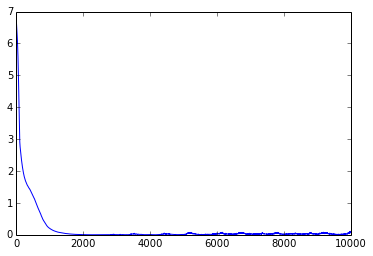

In [136]:
fcn = nn.FCN([x0.shape[1], 32, 32, 1], l2_reg=0.0, step_size=1e-3)
ret = run_net(fcn, prepare_data_for_fcn)

In [217]:
gamma ** eval_all(fcn, task)

array([[ 0.73432627,  0.78764371,  0.64861677,  0.56928871,  0.75869194,
         1.        ,  0.55313912,  0.57499401],
       [ 0.82650828,  0.73088526,  0.9532837 ,  0.82583022,  0.78084654,
         0.75213178,  0.48583772,  0.32932431],
       [ 0.88862115,  0.76932102,  0.90125413,  0.76132445,  0.6659925 ,
         0.67019075,  0.50843917,  0.52920588],
       [ 0.64721533,  0.80612622,  0.88035968,  0.73631549,  0.70636796,
         0.6092751 ,  0.55750843,  0.49514534],
       [ 0.6186785 ,  1.01005232,  0.75703389,  0.65582119,  0.60202559,
         0.57930835,  0.50483638,  0.43914652],
       [ 0.57417944,  0.66256259,  0.6079045 ,  0.8526713 ,  0.5559216 ,
         0.52874047,  0.43548434,  0.41421943],
       [ 0.78896265,  0.81275579,  0.6025241 ,  0.86944424,  0.51249743,
         0.54216896,  0.45418238,  0.48647993],
       [ 0.56321619,  0.60452749,  0.65751565,  0.89856734,  0.4426956 ,
         0.51258862,  0.68516556,  0.31110798]])

In [216]:
solve_task_by_value_iteration(task)

array([[ 0.56942219,  0.64720752,  0.7403647 ,  0.84739048,  0.97017917,
         1.        ,  0.97047668,  0.85319813],
       [ 0.51245361,  0.57955977,  0.65933834,  0.7500985 ,  0.85307867,
         0.96451746,  0.85358467,  0.75545863],
       [ 0.45346569,  0.51069286,  0.5803642 ,  0.65978944,  0.74964175,
         0.83816906,  0.75046857,  0.66837337],
       [ 0.40114527,  0.44951339,  0.51053042,  0.58030708,  0.65840985,
         0.72907199,  0.65959758,  0.59110294],
       [ 0.35476362,  0.395732  ,  0.44910869,  0.51035224,  0.57804104,
         0.63471837,  0.57958342,  0.5225731 ],
       [ 0.31367034,  0.34844446,  0.39509163,  0.44879062,  0.50731853,
         0.55300435,  0.50918114,  0.46182908],
       [ 0.27735527,  0.30700409,  0.34773117,  0.3947267 ,  0.44525232,
         0.48227352,  0.44738492,  0.40811556],
       [ 0.2466945 ,  0.27367076,  0.30907075,  0.34928036,  0.3930808 ,
         0.42347824,  0.39541861,  0.36263983]])

In [215]:
x0 = ret['x0']
task = GridWorldUltimate.create_from_state(x0_t[0,:].ravel(), H, W)
V = compute_value_by_policy(fcn, task)
print np.array(V).reshape(H, W)

[[ 0.00349134  0.00344813  0.00510543  0.04994452  0.89682446  0.
   0.94086085  0.28949062]
 [ 0.00339287  0.00289898  0.00312479  0.00920323  0.09369705  0.92302596
   0.78855466  0.27770072]
 [ 0.00335279  0.00271178  0.00297953  0.00760285  0.10578363  0.74052113
   0.61324459  0.18323256]
 [ 0.00287935  0.00168833  0.00260191  0.00312686  0.00965051  0.04543978
   0.06679851  0.06363424]
 [ 0.00165338  0.00155538  0.00201229  0.00705041  0.00981488  0.03822198
   0.03488885  0.03145551]
 [ 0.00246128  0.00177767  0.00690406  0.00738552  0.00791081  0.03198377
   0.02697874  0.00988887]
 [ 0.00250893  0.00248997  0.00715253  0.00737023  0.00750033  0.02568639
   0.00939692  0.00799751]
 [ 0.00227858  0.0024976   0.00713906  0.00733502  0.00671053  0.00850744
   0.00778546  0.00701874]]


In [198]:
hcnn = MiniPacmanHCNN(H, W, l2_reg=0.0, step_size=1e-3)
run_net(hcnn, prepare_data_for_cnn)
task = GridWorldUltimate.create_from_state(x0[1,:].ravel(), H, W)
compute_value_by_policy(hcnn, task, num_iter = 100)

KeyboardInterrupt: 